# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

In [1]:

from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/DELTARUNE/dataset.zip ./
!unzip dataset.zip


Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
   creating: dataset/scenes/
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: dataset/scenes/scene_9.jpg  
  inflating: __MACOSX/dataset/scenes/._scene_9.jpg  
  inflating: dataset/scenes/scene_8.jpg  
  inflating: __MACOSX/dataset/scenes/._scene_8.jpg  
  inflating: dataset/scenes/scene_20.jpg  
  inflating: __MACOSX/dataset/scenes/._scene_20.jpg  
  inflating: dataset/scenes/scene_21.jpg  
  inflating: __MACOSX/dataset/scenes/._scene_21.jpg  
  inflating: dataset/scenes/scene_23.jpg  
  inflating: __MACOSX/dataset/scenes/._scene_23.jpg  
  inflating: dataset/scenes/scene_22.jpg  
  inflating: __MACOSX/dataset/scenes/._scene_22.jpg  
  inflating: dataset/scenes/scene_26.jpg  
  inflating: __MACOSX/dataset/scenes/._scene_26.jpg  
  inflating: dataset/scenes/scene_27.jpg  
  inflating: __MACOSX/dataset/scenes/._scene_27.jpg  
  inflating: datas

In [2]:
"""
# Define the URL to the dataset.zip file in the GitHub repository
dataset_url = 'https://github.com/andreeado/ipcv/blob/main/dataset.zip' # Replace with the actual URL

# Download the dataset using wget
!wget {dataset_url}

# Unzip the dataset
!unzip dataset.zip -o # Use -o to overwrite existing files if necessary

"""

"\n# Define the URL to the dataset.zip file in the GitHub repository\ndataset_url = 'https://github.com/andreeado/ipcv/blob/main/dataset.zip' # Replace with the actual URL\n\n# Download the dataset using wget\n!wget {dataset_url}\n\n# Unzip the dataset\n!unzip dataset.zip -o # Use -o to overwrite existing files if necessary\n\n"

In [3]:
# Demo: run improved multi-instance detector for one model/scene
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Prepare paths
scenes_paths = [f"dataset/scenes/scene_{i}.jpg" for i in range(29)]
model_paths = [f"dataset/models/model_{i}.png" for i in range(22)]

# Load images (scenes color, scenes grayscale, models grayscale)
scenes = [cv2.imread(path) for path in scenes_paths]
scenes_grayscale = [cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY) for scene in scenes]
models = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in model_paths]

# Precompute SIFT keypoints and descriptors for all models and scenes for performance
sift = cv2.SIFT_create()
models_kp_des = {}  # dict: idx -> {img, kp, des}
for i, img in enumerate(models):
    if img is None:
        models_kp_des[i] = {'img': None, 'kp': None, 'des': None}
        continue
    kp, des = sift.detectAndCompute(img, None)
    models_kp_des[i] = {'img': img, 'kp': kp, 'des': des}

scenes_kp_des = {}  # dict: idx -> {img_color, img_gray, kp, des}
for i, (img_color, img_gray) in enumerate(zip(scenes, scenes_grayscale)):
    if img_gray is None or img_color is None:
        scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': None, 'des': None}
        continue
    kp_s, des_s = sift.detectAndCompute(img_gray, None)
    scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': kp_s, 'des': des_s}

print('Precomputed SIFT keypoints/descriptors for', len(models_kp_des), 'models and', len(scenes_kp_des), 'scenes')

Precomputed SIFT keypoints/descriptors for 22 models and 29 scenes


In [8]:
# Improved multi-instance detection utilities



lowes_ratio = 0.8
min_match_percent = 0.02
usac_error = 3

sift_scene = cv2.SIFT_create(sigma=0.4)

def instance_in_scene(processed_model, img_scene: np.array):
    """Given a processed model (dict with keys 'image','keypoints','descriptors') and a grayscale scene image,
    this computes one instance (if any), masks it out in the provided scene image and returns the polygon (4 corners) in scene coords."""
    # SIFT feature extraction on the scene
    kp_scene, des_scene = sift_scene.detectAndCompute(img_scene, None)

    # Feature matching
    matcher = cv2.BFMatcher()
    if processed_model.get('descriptors') is None or des_scene is None:
        return None
    matches = matcher.knnMatch(processed_model['descriptors'], des_scene, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m_n in matches:
        if len(m_n) != 2:
            continue
        m, n = m_n
        if m.distance < lowes_ratio * n.distance:
            good_matches.append(m)

    if len(good_matches) < min_match_percent * len(matches):
        return None

    h, w = processed_model['image'].shape
    pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]])

    # Extract source and destination points
    src_pts = np.float32([processed_model['keypoints'][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    try:
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.USAC_ACCURATE, usac_error)
        if M is None or mask is None:
            return None
    except Exception:
        return None

    # Transform model corners to scene coordinates
    dst = cv2.perspectiveTransform(np.array([pts]), M)

    # Mask scene in-place so repeated calls won't return the same instance
    img_scene[:] = cv2.fillPoly(img_scene.copy(), [np.int32(dst)], (0, 0, 0))

    return dst[0,:,:]

# High-level runner: for a given model and scene image, iteratively find instances by masking each found instance and rerunning
def detect_multiple_instances(processed_model, img_scene_color: np.array, img_scene_gray: np.array, max_instances=10, debug=False):
    results = []
    # work on a copy of the grayscale scene that we will modify (masking out found instances)
    working_gray = img_scene_gray.copy()
    for i in range(max_instances):
        inst = instance_in_scene(processed_model, working_gray)
        if inst is None:
            break
        # compute axis-aligned bbox and area for reporting
        pts = np.int32(inst)
        x_coords = pts[:,0]
        y_coords = pts[:,1]
        x_min, x_max = int(x_coords.min()), int(x_coords.max())
        y_min, y_max = int(y_coords.min()), int(y_coords.max())
        area = int((x_max - x_min) * (y_max - y_min))
        results.append({'corners': pts.tolist(), 'bbox': (x_min, y_min, x_max, y_max), 'area': area})
    return results

# Helper to run across all models/scenes using precomputed kp/des
def run_all_models_on_scenes(models_kp_des, scenes_kp_des, min_matches=30, max_instances=10, visualize=True):
    all_results = {}
    for i_model, mdl in models_kp_des.items():
        if mdl.get('img') is None:
            continue
        processed = {'image': mdl['img'], 'keypoints': mdl['kp'], 'descriptors': mdl['des']}
        for i_scene, sc in scenes_kp_des.items():
            if sc.get('img_gray') is None:
                continue
            instances = detect_multiple_instances(processed, sc['img_color'], sc['img_gray'], max_instances=max_instances)
            all_results[(i_model, i_scene)] = instances
            print(f'Model {i_model} in Scene {i_scene}: found {len(instances)} instance(s)')
            if visualize and len(instances) > 0:
                img_draw = sc['img_color'].copy()
                for inst in instances:
                    x_min, y_min, x_max, y_max = inst['bbox']
                    cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10,6))
                plt.imshow(img_rgb)
                plt.title(f'Model {i_model} — Scene {i_scene} — {len(instances)} instances')
                plt.axis('off')
                plt.show()
    return all_results

In [7]:
# Run and visualize all models per scene (show all models' detections together)
all_detection_results = {}
n_models = len(models_kp_des)
n_scenes = len(scenes_kp_des)
# Prepare a harmonic color palette for visualization using matplotlib's inferno
import matplotlib
cmap = matplotlib.colormaps["inferno"]
# inferno returns RGBA floats in [0,1]; convert to 0-255 and to BGR for OpenCV
model_colors = {}
for i in range(n_models):
    rgba = cmap(i % cmap.N)
    r, g, b = int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255)
    # OpenCV uses BGR ordering
    model_colors[i] = (int(b), int(g), int(r))
for i_scene in range(n_scenes):
    sc = scenes_kp_des.get(i_scene)
    if sc is None or sc.get('img_gray') is None:
        continue
    img_color_orig = sc['img_color']
    img_color = img_color_orig.copy()
    img_gray = sc['img_gray'].copy()
    # For per-scene visualization we keep a separate working copy of the gray image for detection masking
    working_gray_for_models = img_gray.copy()
    scene_results = {}
    # Run all models on this scene and draw boxes with distinct colors
    print(f'\nScene {i_scene}:') # Print scene number
    instance_counts = [] # List to store instance counts for this scene
    for i_model in range(n_models):
        mdl = models_kp_des.get(i_model)
        if mdl is None or mdl.get('img') is None:
            continue
        processed = {'image': mdl['img'], 'keypoints': mdl['kp'], 'descriptors': mdl['des']}
        # Use a copy of the working gray so that each model's detections do not mask out others (we want to show all matches)
        instances = detect_multiple_instances(processed, img_color, working_gray_for_models.copy(), max_instances=10)
        scene_results[i_model] = instances
        all_detection_results[(i_model, i_scene)] = instances
        if len(instances) > 0: # Only add to list if instances are found
          instance_counts.append(f'Model {i_model}: {len(instances)} instance(s)') # Add instance count to the list
        # draw instances for this model with its color
        color = model_colors.get(i_model, (0,255,0))
        for inst in instances:
            x_min, y_min, x_max, y_max = inst['bbox']
            cv2.rectangle(img_color, (x_min, y_min), (x_max, y_max), color, 2)
            # optional: put model id near the box
            cv2.putText(img_color, f'M{ i_model }', (x_min, max(y_min-6,0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    # After drawing all models for this scene, show a combined image
    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,7))
    plt.imshow(img_rgb)
    plt.title(f'Scene {i_scene}')
    plt.axis('off')
    plt.show()
    # Print instance counts for all models in this scene on one line
    print(' | '.join(instance_counts))
# all_detection_results contains detection lists for every (model,scene) pair
print('Completed all runs — results stored in all_detection_results')


Scene 0:


TypeError: instance_in_scene() got an unexpected keyword argument 'debug'

Alcune box sono fatte male

Problemi:

Scene 9 e 10:
Solo uno dei modelli 4 viene visto

Scena 15:
Sono uno dei modelli 12 viene visto

Scena 16:
Nessuno dei modelli 12 viene visto

Scena 18:
i modelli 8 e 9 vengono confusi

Scena 27:
Solo uno dei modelli 3 viene visto


In [ ]:
import pickle

# Save the all_detection_results dictionary to a pickle file
with open('all_detection_results_SIFT.pkl', 'wb') as f:
    pickle.dump(all_detection_results, f)

print("all_detection_results saved to 'all_detection_results.pkl'")

In [9]:
# GA helpers and imports
import copy
import random
import json
import os
import datetime
import matplotlib.pyplot as plt
from IPython.display import display, Image
import numpy as np
import cv2

# Baseline hyperparameters (use these as the starting point)
DEFAULT_HP = {
 'lowes_ratio': 0.8,
 'min_match_percent': 0.02,
 'usac_error': 3,
 'sift_sigma': 0.4,
}

def random_candidate(base=DEFAULT_HP, pct_mut=0.2):
 """Create a randomized candidate by perturbing baseline values."""
 c = copy.deepcopy(base)
 c['lowes_ratio'] = max(0.1, min(0.95, random.gauss(base['lowes_ratio'], pct_mut * base['lowes_ratio'])))
 c['min_match_percent'] = max(0.001, min(0.2, random.gauss(base['min_match_percent'], pct_mut * base['min_match_percent'])))
 c['usac_error'] = max(0.5, abs(random.gauss(base['usac_error'], max(0.1, pct_mut * base['usac_error']))))
 c['sift_sigma'] = max(0.1, min(2.0, random.gauss(base['sift_sigma'], pct_mut * base['sift_sigma'])))
 return c

def mutate(candidate, pct_mut=0.15):
 c = copy.deepcopy(candidate)
 c['lowes_ratio'] = max(0.1, min(0.95, random.gauss(candidate['lowes_ratio'], pct_mut * candidate['lowes_ratio'])))
 c['min_match_percent'] = max(0.001, min(0.2, random.gauss(candidate['min_match_percent'], pct_mut * candidate['min_match_percent'])))
 c['usac_error'] = max(0.5, abs(random.gauss(candidate['usac_error'], pct_mut * candidate['usac_error'])))
 c['sift_sigma'] = max(0.1, min(2.0, random.gauss(candidate['sift_sigma'], pct_mut * candidate['sift_sigma'])))
 return c

def crossover(a, b):
 """Uniform crossover between two parent dicts."""
 child = {}
 for k in a.keys():
  child[k] = a[k] if random.random() < 0.5 else b[k]
 return child

def candidate_to_str(c):
 return json.dumps(c, indent=2)

In [10]:
# GA core: apply params, evaluate candidate(s) on scenes, run one generation
def apply_candidate_params(candidate):
 """Apply candidate hyperparameters to globals used by the detector."""
 global lowes_ratio, min_match_percent, usac_error, sift_scene
 lowes_ratio = candidate['lowes_ratio']
 min_match_percent = candidate['min_match_percent']
 usac_error = candidate['usac_error']
 # recreate SIFT used by instance_in_scene/detection
 try:
  sift_scene = cv2.SIFT_create(sigma=candidate.get('sift_sigma', 0.4))
 except Exception:
  # Some OpenCV builds may not accept sigma parameter; fallback to default SIFT
  sift_scene = cv2.SIFT_create()

def evaluate_candidate_on_scenes(candidate, model_idx, scene_indices, max_instances=10):
 """Return simple visuals and counts for visualization. Relies on detect_multiple_instances and precomputed kp/des dicts."""
 apply_candidate_params(candidate)
 results = {}
 visuals = [] # list of tuples: (scene_idx, img_with_boxes (BGR), total_instances)
 for si in scene_indices:
  sc = scenes_kp_des.get(si)
  if sc is None or sc.get('img_gray') is None:
   continue
  img_color = sc['img_color'].copy()
  img_gray = sc['img_gray'].copy()
  if model_idx is None:
   total = 0
   for mid, mdl in models_kp_des.items():
    if mdl.get('img') is None:
     continue
    processed = {'image': mdl['img'], 'keypoints': mdl['kp'], 'descriptors': mdl['des']}
    instances = detect_multiple_instances(processed, img_color, img_gray, max_instances=max_instances)
    for inst in instances:
     x_min, y_min, x_max, y_max = inst['bbox']
     cv2.rectangle(img_color, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
    total += len(instances)
   results[si] = {'total_instances': total}
   visuals.append((si, img_color, total))
  else:
   mdl = models_kp_des.get(model_idx)
   if mdl is None or mdl.get('img') is None:
    results[si] = {'total_instances': 0}
    visuals.append((si, img_color, 0))
    continue
   processed = {'image': mdl['img'], 'keypoints': mdl['kp'], 'descriptors': mdl['des']}
   instances = detect_multiple_instances(processed, img_color, img_gray, max_instances=max_instances)
   for inst in instances:
    x_min, y_min, x_max, y_max = inst['bbox']
    cv2.rectangle(img_color, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
   results[si] = {'total_instances': len(instances)}
   visuals.append((si, img_color, len(instances)))
 return results, visuals

def run_generation(population, model_idx, scene_indices):
 """Evaluate a population (expected length 4) and return per-candidate visuals/results."""
 assert len(population) == 4, 'Population must contain exactly 4 candidates'
 eval_results = []
 visuals_per_candidate = []
 for cand in population:
  res, vis = evaluate_candidate_on_scenes(cand, model_idx, scene_indices)
  eval_results.append(res)
  visuals_per_candidate.append(vis)
 return eval_results, visuals_per_candidate

In [16]:
# Visualization and human selection (2x2 grid)
def show_candidates_comparison(population, visuals_per_candidate, scene_indices):
    """Display a 2x2 grid for each scene, showing the selected scenes for that candidate."""
    assert len(population) == 4, 'Expected 4 candidates'

    for scene_idx in scene_indices:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        fig.suptitle(f'Scene {scene_idx}', fontsize=16)

        for i, ax in enumerate(axes):
            # Find the visual data for the current candidate and scene
            scene_visuals = [v for v in visuals_per_candidate[i] if v[0] == scene_idx]

            if not scene_visuals:
                ax.text(0.5, 0.5, 'No valid visuals for this scene', ha='center', va='center')
                ax.set_title(f'Candidate {i}\n{candidate_to_str(population[i])}')
                ax.axis('off')
                continue

            # Assuming there's only one visual per scene per candidate in this structure
            img_bgr, total_instances, avg_area = scene_visuals[0][1:]
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            ax.imshow(img_rgb)
            ax.set_title(f'Candidate {i} - Instances: {total_instances}\n{candidate_to_str(population[i])}')
            ax.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()


def human_select_best(population, visuals_per_candidate, scene_indices):
    show_candidates_comparison(population, visuals_per_candidate, scene_indices)
    while True:
        choice = input('Select best candidate index (0-3) based on the visualizations, or "s" to skip/stop: ').strip()
        if choice.lower() == 's':
            return None
        try:
            idx = int(choice)
            if 0 <= idx < 4:
                return idx
            else:
                print('Enter 0-3 or s')
        except ValueError:
            print('Enter a number 0-3 or s to skip')

In [12]:
# Enhanced evaluation that computes simple metrics and saves artifacts
def evaluate_candidate_with_metrics(candidate, model_idx, scene_indices, max_instances=10):
 """Return metrics and visuals: visuals list of (scene_idx, img_bgr, total_instances, avg_area)."""
 apply_candidate_params(candidate)
 results = {}
 visuals = []
 for si in scene_indices:
  sc = scenes_kp_des.get(si)
  if sc is None or sc.get('img_gray') is None:
   continue
  img_color = sc['img_color'].copy()
  img_gray = sc['img_gray'].copy()
  if model_idx is None:
   total = 0
   areas = []
   for mid, mdl in models_kp_des.items():
    if mdl.get('img') is None:
     continue
    processed = {'image': mdl['img'], 'keypoints': mdl['kp'], 'descriptors': mdl['des']}
    instances = detect_multiple_instances(processed, img_color, img_gray, max_instances=max_instances)
    for inst in instances:
     x_min, y_min, x_max, y_max = inst['bbox']
     cv2.rectangle(img_color, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
     areas.append(inst.get('area', 0))
    total += len(instances)
   avg_area = int(sum(areas)/len(areas)) if len(areas)>0 else 0
   results[si] = {'total_instances': total, 'avg_area': avg_area, 'areas': areas}
   visuals.append((si, img_color, total, avg_area))
  else:
   mdl = models_kp_des.get(model_idx)
   if mdl is None or mdl.get('img') is None:
    results[si] = {'total_instances': 0, 'avg_area': 0, 'areas': []}
    visuals.append((si, img_color, 0, 0))
    continue
   processed = {'image': mdl['img'], 'keypoints': mdl['kp'], 'descriptors': mdl['des']}
   instances = detect_multiple_instances(processed, img_color, img_gray, max_instances=max_instances)
   areas = [inst.get('area', 0) for inst in instances]
   for inst in instances:
    x_min, y_min, x_max, y_max = inst['bbox']
    cv2.rectangle(img_color, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
   avg_area = int(sum(areas)/len(areas)) if len(areas)>0 else 0
   results[si] = {'total_instances': len(instances), 'avg_area': avg_area, 'areas': areas}
   visuals.append((si, img_color, len(instances), avg_area))
 return results, visuals

def save_generation_artifacts(population, visuals_per_candidate, scene_indices, generation, out_dir='ga_artifacts'):
 os.makedirs(out_dir, exist_ok=True)
 fig, axes = plt.subplots(2,2, figsize=(12,10))
 axes = axes.flatten()
 summary = []
 for i, ax in enumerate(axes):
  vis = visuals_per_candidate[i]
  if len(vis) == 0:
   ax.text(0.5, 0.5, 'No valid scenes', ha='center', va='center')
   ax.set_axis_off()
   summary.append({'candidate_idx': i, 'total_instances': 0, 'avg_area': 0})
   continue
  imgs = [cv2.cvtColor(v[1], cv2.COLOR_BGR2RGB) for v in vis]
  widths = [im.shape[1] for im in imgs]
  minw = min(widths)
  resized = [cv2.resize(im, (minw, int(im.shape[0]*minw/im.shape[1])), interpolation=cv2.INTER_AREA) for im in imgs]
  stacked = np.vstack(resized)
  ax.imshow(stacked)
  totals = [int(v[2]) for v in vis]
  avgs = [int(v[3]) for v in vis]
  total_sum = int(sum(totals))
  avg_of_avgs = int(sum(avgs)/len(avgs)) if len(avgs)>0 else 0
  ax.set_title(f'Candidate {i} — total: {total_sum} avg_area: {avg_of_avgs}\n{candidate_to_str(population[i])}')
  ax.axis('off')
  summary.append({'candidate_idx': i, 'total_instances': total_sum, 'avg_area': avg_of_avgs})
 plt.tight_layout()
 fig_path = os.path.join(out_dir, f'gen_{generation:03d}_comparison.png')
 fig.savefig(fig_path)
 plt.close(fig)
 json_path = os.path.join(out_dir, f'gen_{generation:03d}_metrics.json')
 payload = {'generation': generation, 'scene_indices': scene_indices, 'summary': summary}
 with open(json_path, 'w') as f:
  json.dump(payload, f, indent=2)
 return fig_path, json_path

def run_generation_and_save(population, model_idx, scene_indices, generation):
 assert len(population) == 4
 eval_results = []
 visuals_per_candidate = []
 for cand in population:
  res, vis = evaluate_candidate_with_metrics(cand, model_idx, scene_indices)
  eval_results.append(res)
  visuals_per_candidate.append(vis)
 fig_path, json_path = save_generation_artifacts(population, visuals_per_candidate, scene_indices, generation)
 print(f'Saved generation {generation} artifacts: {fig_path}, {json_path}')
 return eval_results, visuals_per_candidate, fig_path, json_path

In [13]:
# Interactive GA loop that saves artifacts and history
def interactive_ga_with_saving(initial_population=None, model_idx=0, generations=5, scene_selector=None, out_dir='ga_artifacts'):
 if initial_population is None:
  population = [random_candidate() for _ in range(4)]
 else:
  assert len(initial_population) == 4
  population = initial_population
 history = []
 os.makedirs(out_dir, exist_ok=True)
 for gen in range(generations):
  print(f'=== Generation {gen} ===')
  if scene_selector is not None:
   scene_indices = scene_selector(gen)
  else:
   raw = input('Enter comma-separated scene indices (e.g. 0,2,5): ')
   scene_indices = [int(x.strip()) for x in raw.split(',') if x.strip()!='']

  eval_results, visuals, fig_path, json_path = run_generation_and_save(population, model_idx, scene_indices, gen)

  # show the saved figure in the notebook
  try:
   display(Image(filename=fig_path))
  except Exception:
   pass

  choice = human_select_best(population, visuals, scene_indices)
  if choice is None:
   print('Skipping selection — stopping GA early')
   break

  chosen = population[choice]
  history.append({'generation': gen, 'chosen_idx': choice, 'candidate': chosen, 'scene_indices': scene_indices, 'fig': fig_path, 'metrics': json_path, 'time': datetime.datetime.now().isoformat()})

  # next population: keep chosen and create 3 offspring
  new_pop = [chosen]
  while len(new_pop) < 4:
   p2 = random.choice(population)
   child = crossover(chosen, p2)
   child = mutate(child)
   new_pop.append(child)
  population = new_pop

  # save history incrementally
  with open(os.path.join(out_dir, 'ga_history.json'), 'w') as f:
   json.dump(history, f, indent=2)

 print('GA run complete. History saved to', os.path.join(out_dir, 'ga_history.json'))
 return history

=== Generation 0 ===
Enter comma-separated scene indices (e.g. 0,2,5): 10,11,15,
Saved generation 0 artifacts: ga_artifacts/gen_000_comparison.png, ga_artifacts/gen_000_metrics.json


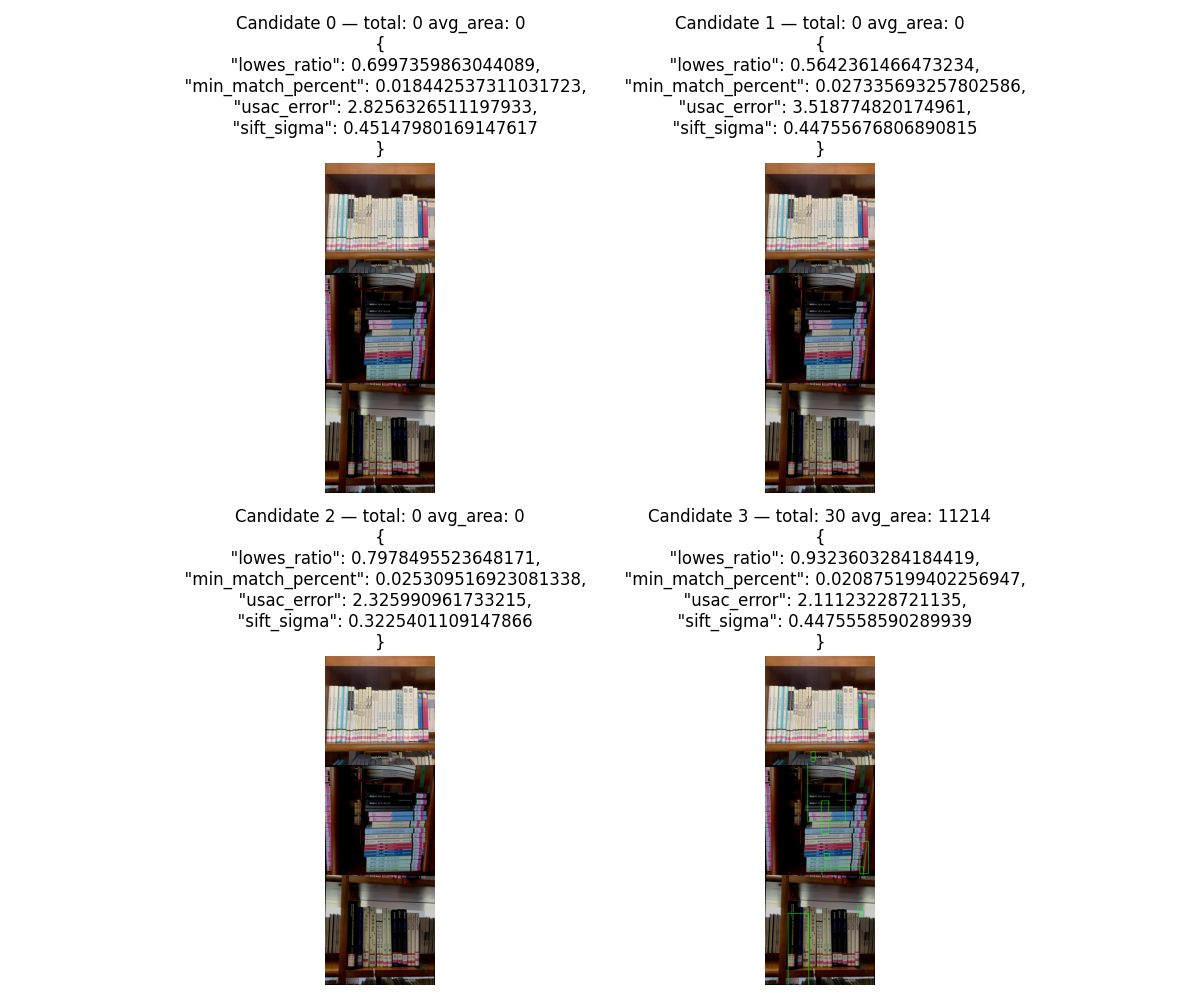

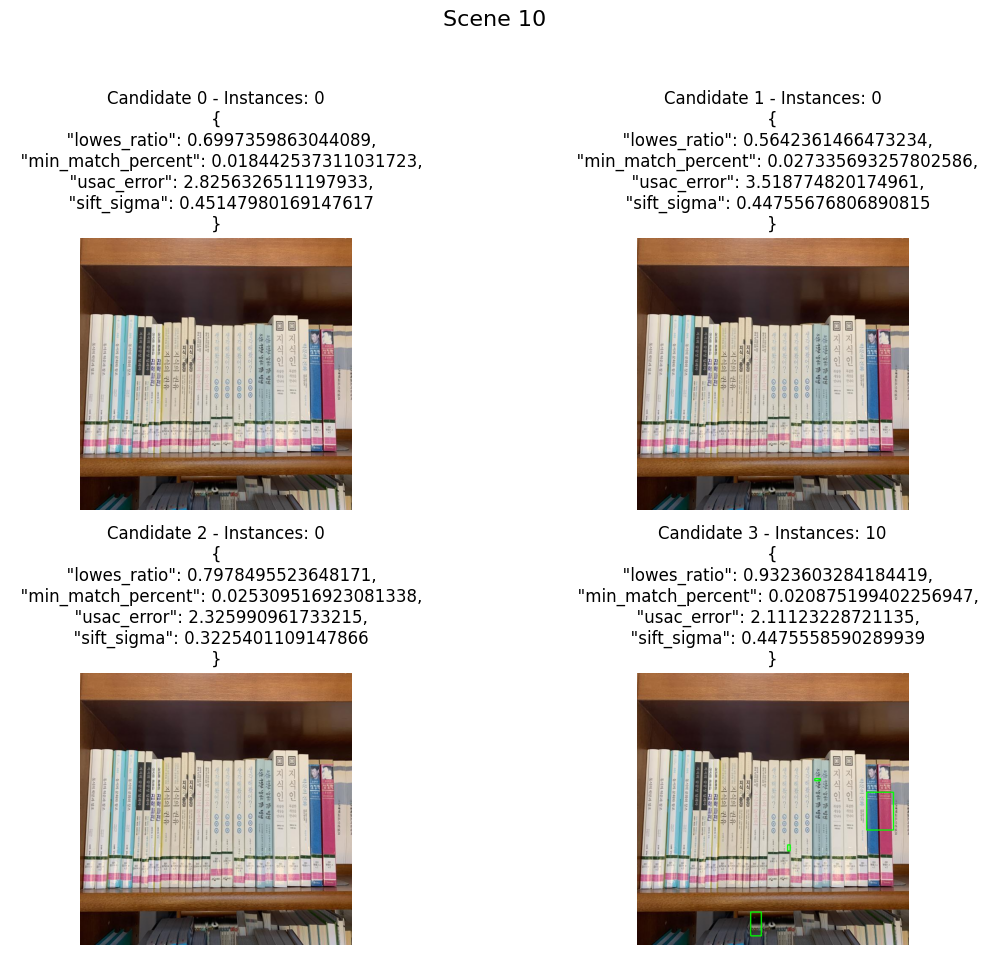

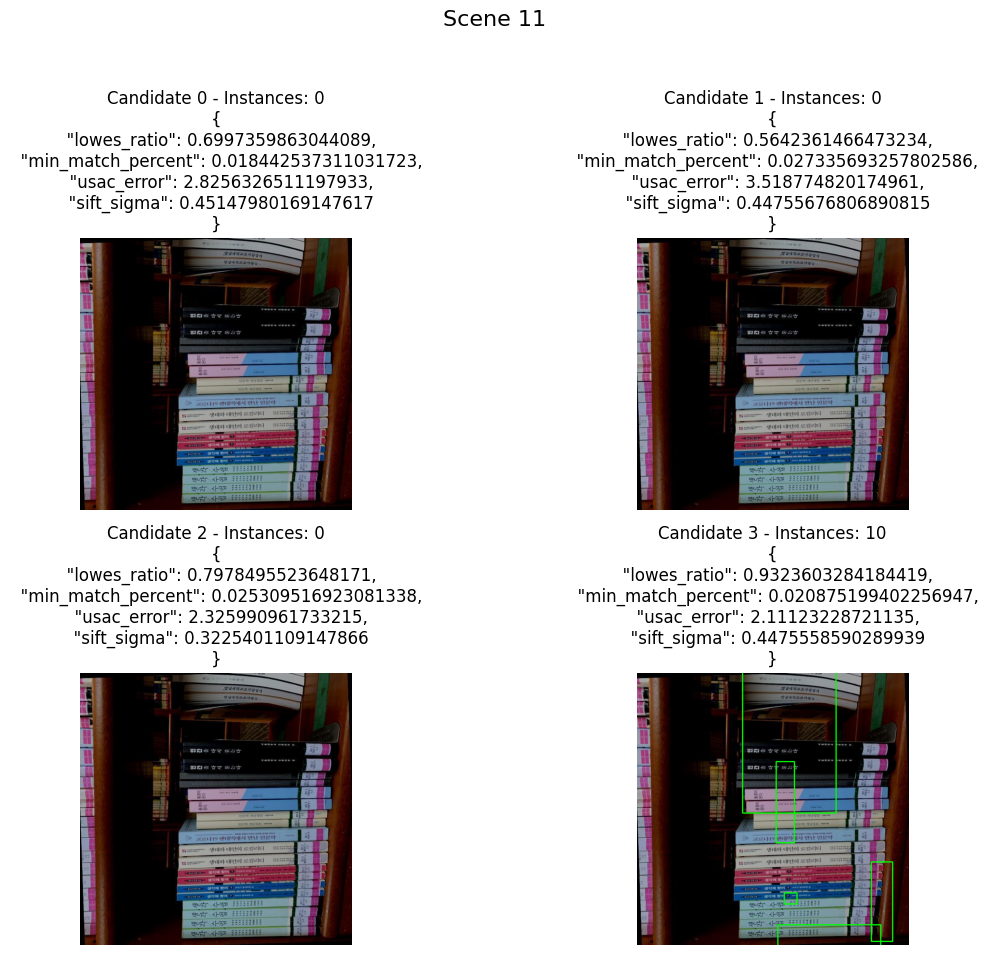

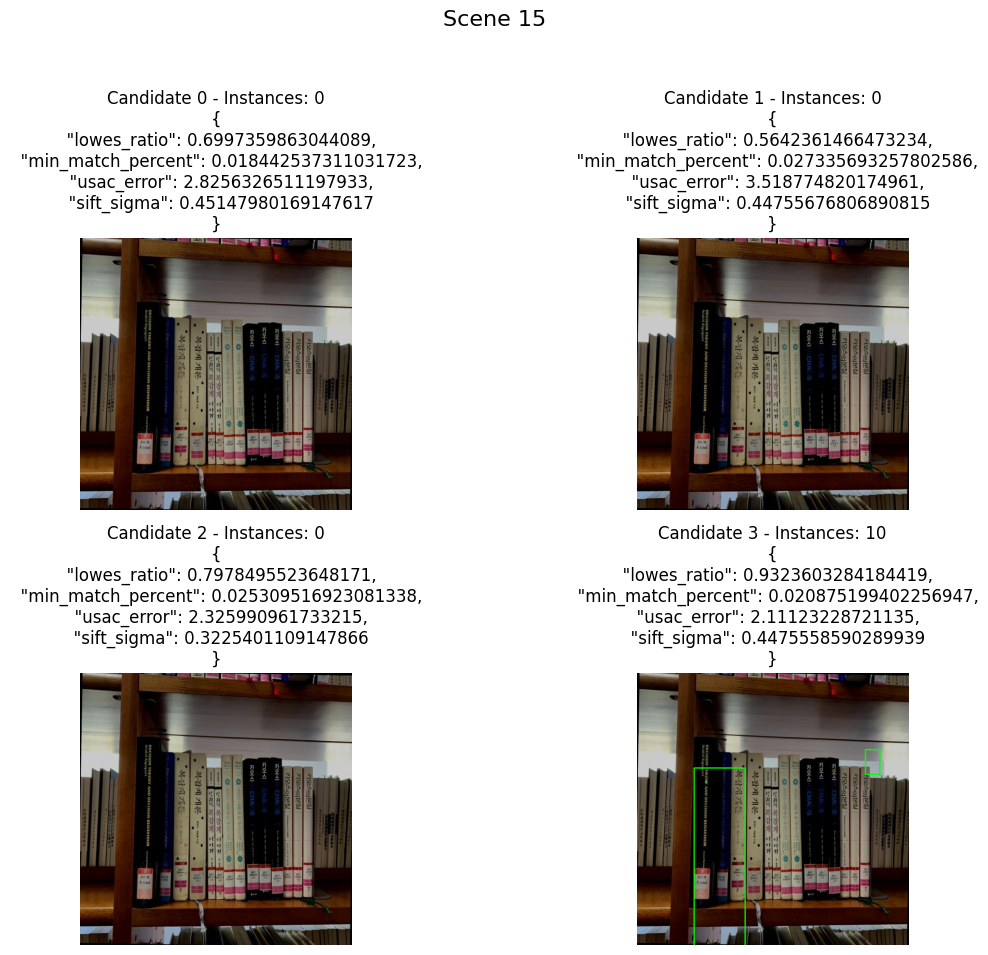

Select best candidate index (0-3) based on the visualizations, or "s" to skip/stop: 2
=== Generation 1 ===
Enter comma-separated scene indices (e.g. 0,2,5): 10,11,15,16,17,27
Saved generation 1 artifacts: ga_artifacts/gen_001_comparison.png, ga_artifacts/gen_001_metrics.json


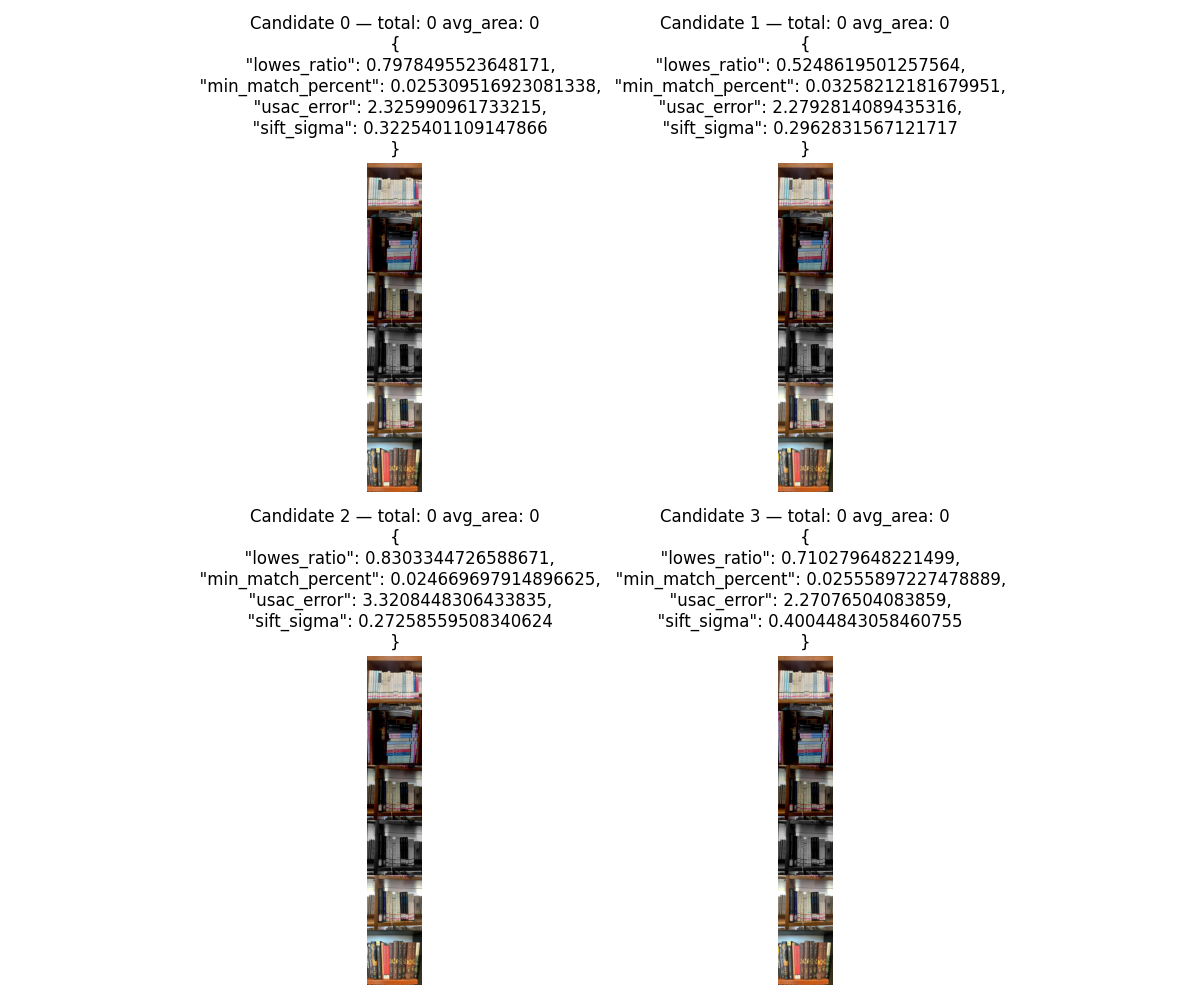

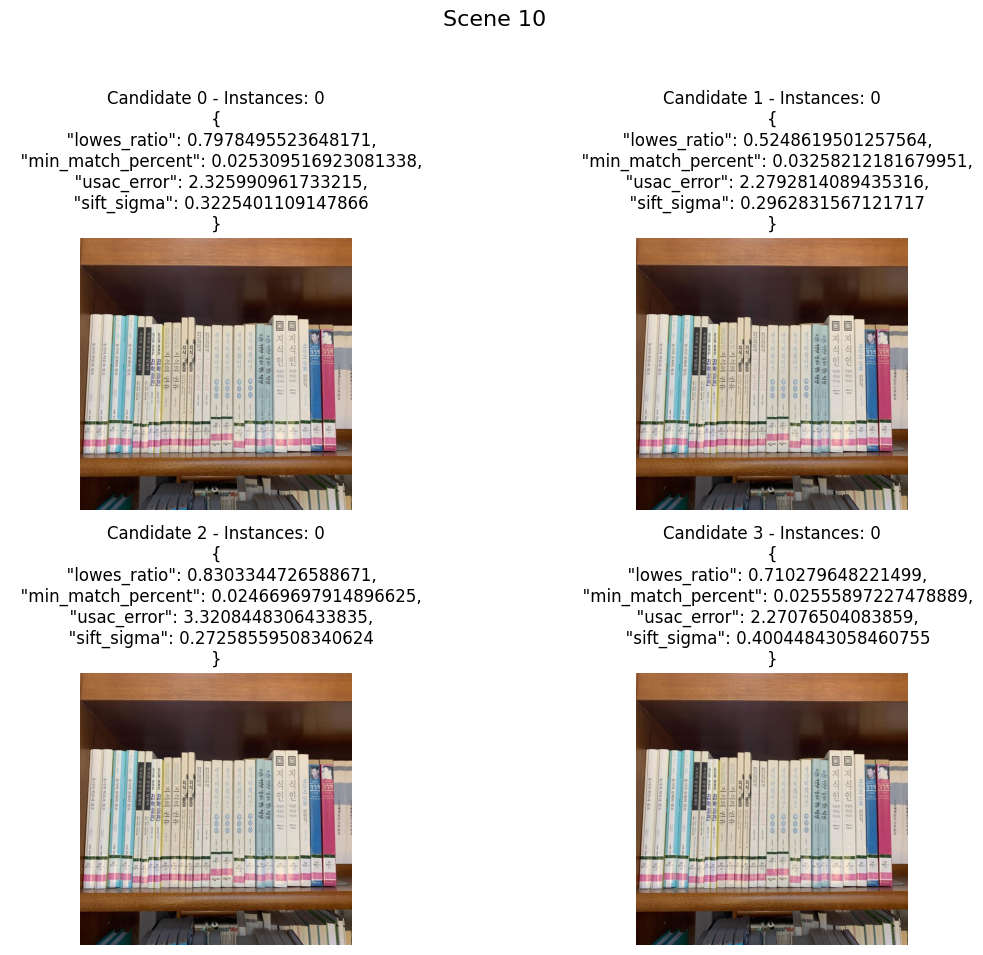

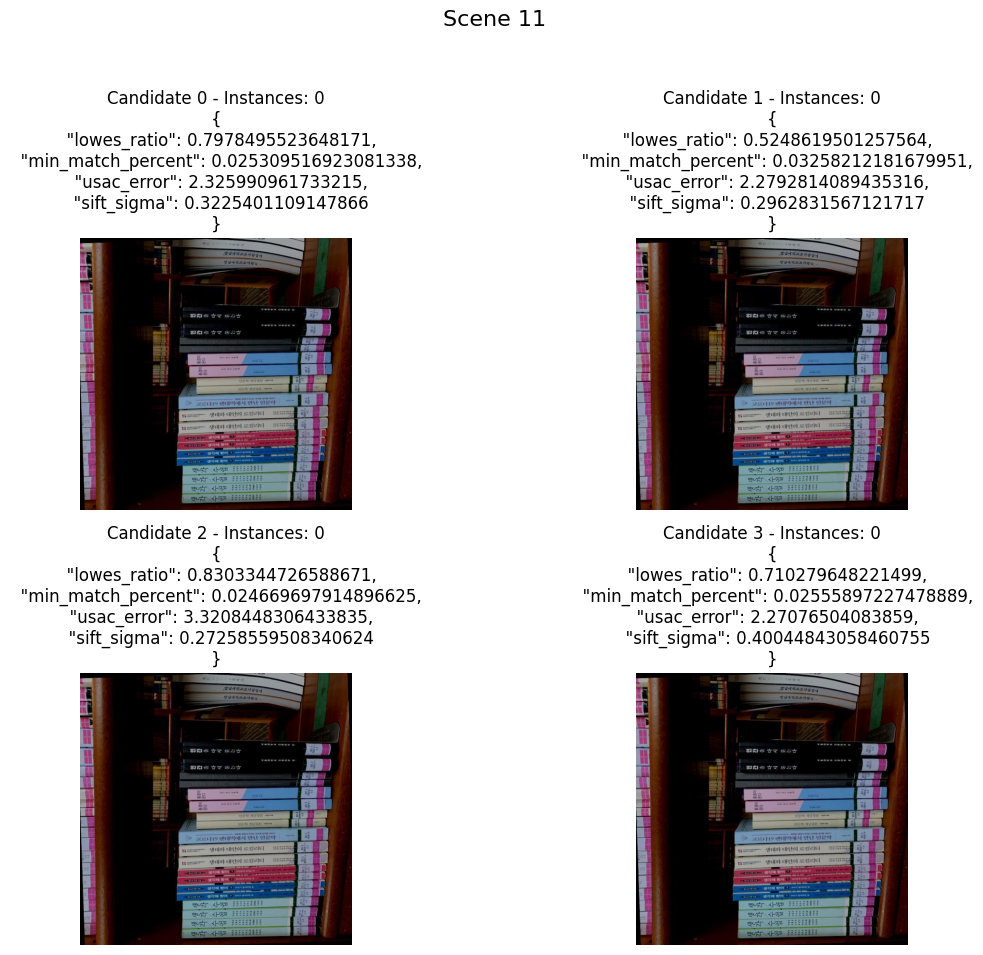

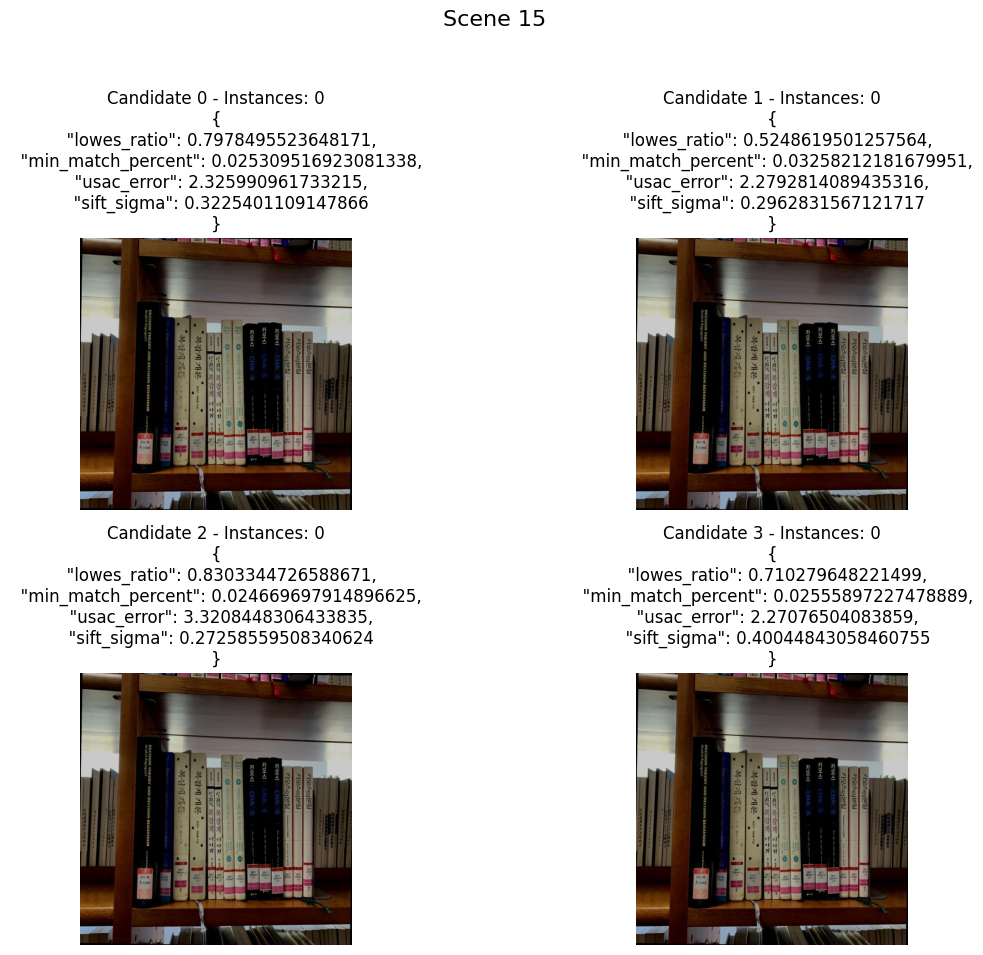

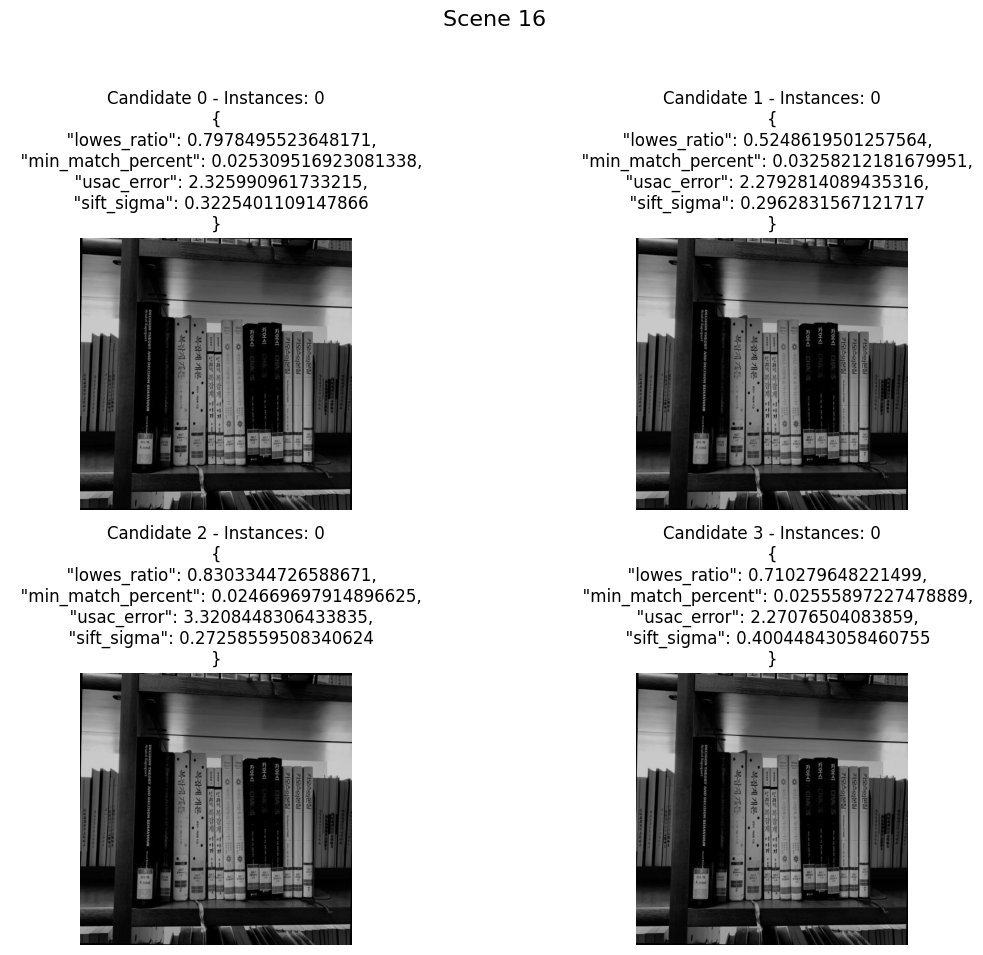

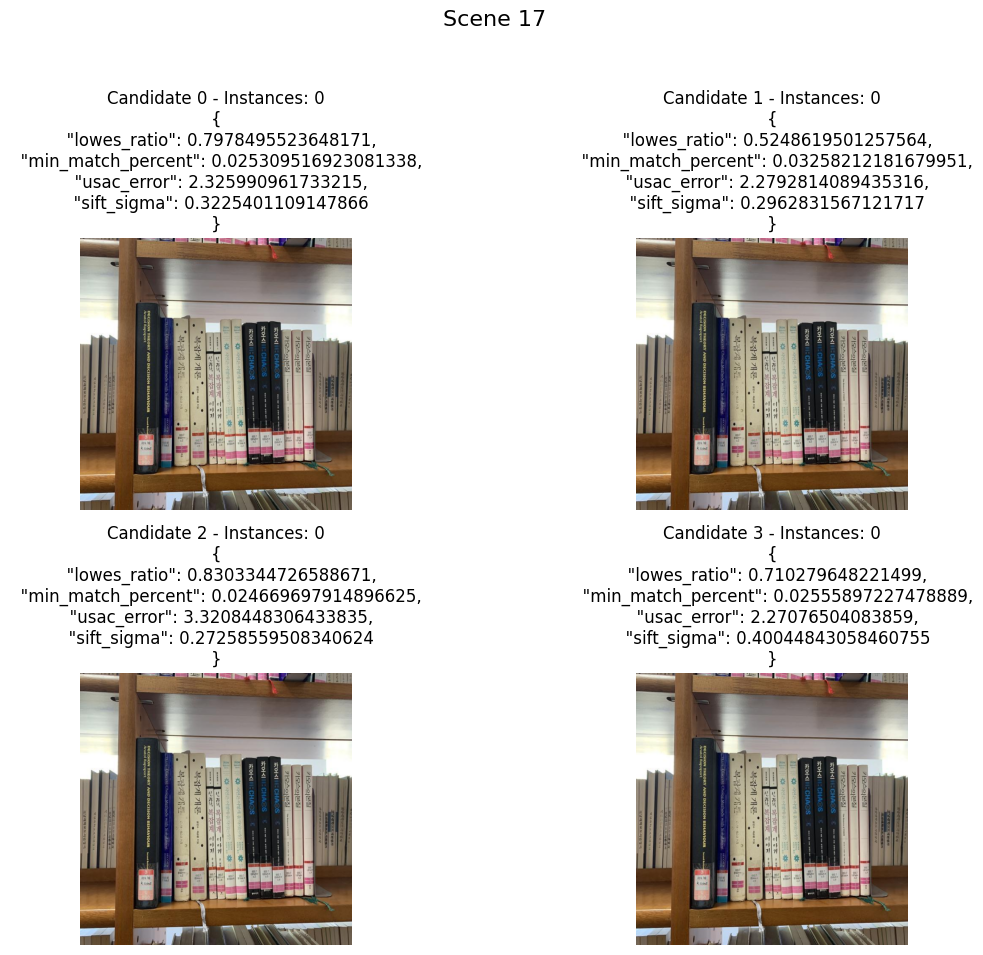

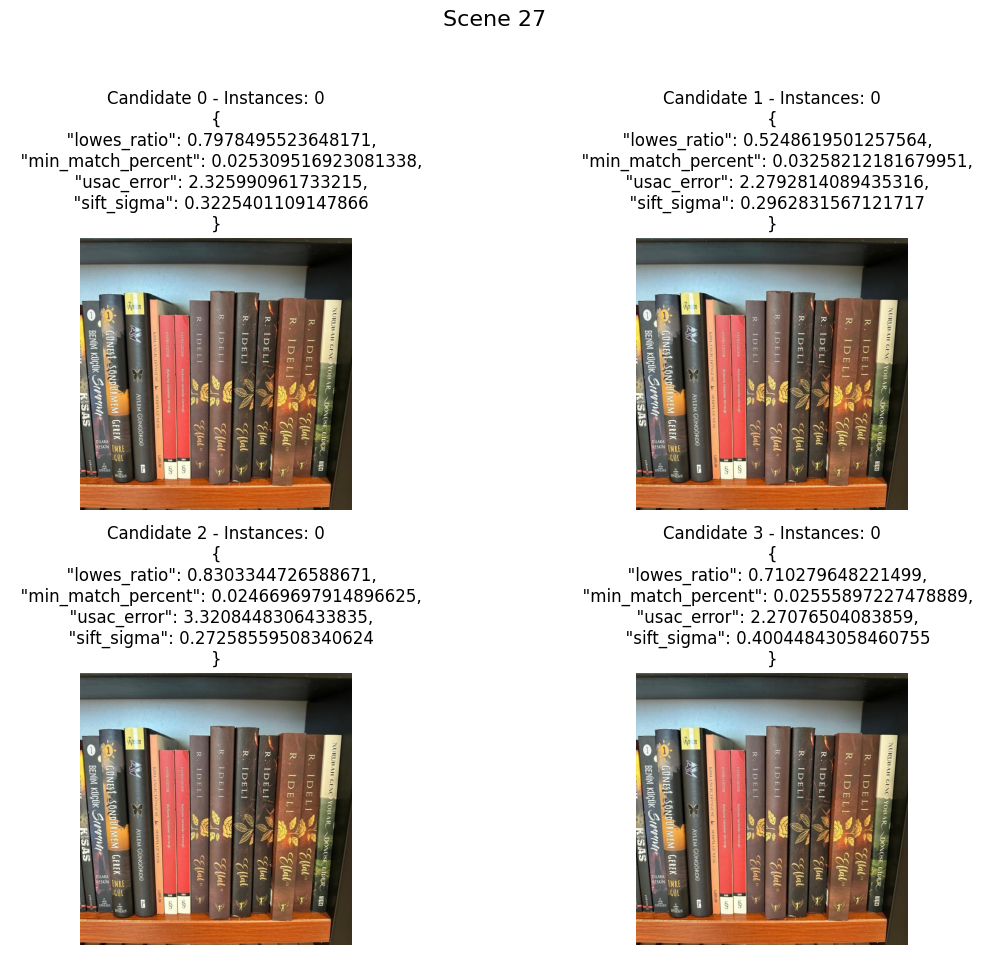

KeyboardInterrupt: Interrupted by user

In [17]:
# Run the interactive GA
# You can customize the number of generations and the model index to focus on
interactive_ga_with_saving(model_idx=0, generations=8)